# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

![Autoencoder](assets/autoencoder_1.png)

In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [3]:
%matplotlib inline

import numpy as np
import tensorflow as tf
old_v = tf.logging.get_verbosity()
# set tf not output warning
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib.pyplot as plt

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Below I'm plotting an example image from the MNIST dataset. These are 28x28 grayscale images of handwritten digits.

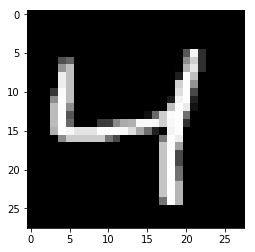

In [6]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building basically the simplest autoencoder with a **single ReLU hidden layer**. This layer will be used as the compressed representation. Then, the encoder is the input layer and the hidden layer. The decoder is the hidden layer and the output layer. Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values matching the input.

![Autoencoder architecture](assets/simple_autoencoder.png)


> **Exercise:** Build the graph for the autoencoder in the cell below. The input images will be flattened into 784 length vectors. The targets are the same as the inputs. And there should be one hidden layer with a ReLU activation and an output layer with a sigmoid activation. Feel free to use TensorFlow's higher level API, `tf.layers`. For instance, you would use [`tf.layers.dense(inputs, units, activation=tf.nn.relu)`](https://www.tensorflow.org/api_docs/python/tf/layers/dense) to create a fully connected layer with a ReLU activation. The loss should be calculated with the cross-entropy loss, there is a convenient TensorFlow function for this `tf.nn.sigmoid_cross_entropy_with_logits` ([documentation](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)). You should note that `tf.nn.sigmoid_cross_entropy_with_logits` takes the logits, but to get the reconstructed images you'll need to pass the logits through the sigmoid function.

In [24]:
# Size of the encoding layer (the hidden layer)
encoding_dim = 64 #32 # feel free to change this value
output_dim = input_dim = 28*28

# Input and target placeholders
inputs_ = tf.placeholder(shape=(None, input_dim),dtype=tf.float32, name="inputs")
targets_ = tf.placeholder(shape=(None, output_dim), dtype=tf.float32, name="outputs")

# Output of hidden layer, single fully connected layer here with ReLU activation
encoded = tf.layers.dense(inputs=inputs_, 
                          units=encoding_dim,
                          activation=tf.nn.relu)
# no kernel initializer, the glorot_uniform_initializer is called
# reference: https://stackoverflow.com/questions/43284047/what-is-the-default-kernel-initializer-in-tf-layers-conv2d-and-tf-layers-dense

# Output layer logits, fully connected layer with no activation
logits = tf.layers.dense(inputs=encoded, 
                         units=output_dim,
                         activation=None)
# Sigmoid output from logits
decoded = tf.nn.sigmoid(logits)

# Sigmoid cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
# Mean of the loss
cost = tf.reduce_mean(loss)

# Adam optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

## Training

In [25]:
# Create the session
sess = tf.Session()

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss. 

Calling `mnist.train.next_batch(batch_size)` will return a tuple of `(images, labels)`. We're not concerned with the labels here, we just need the images. Otherwise this is pretty straightfoward training with TensorFlow. We initialize the variables with `sess.run(tf.global_variables_initializer())`. Then, run the optimizer and get the loss with `batch_cost, _ = sess.run([cost, opt], feed_dict=feed)`.

In [26]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        feed = {inputs_: batch[0], targets_: batch[0]}
        batch_cost, _ = sess.run([cost, opt], feed_dict=feed)

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6957
Epoch: 1/20... Training loss: 0.6892
Epoch: 1/20... Training loss: 0.6830
Epoch: 1/20... Training loss: 0.6759
Epoch: 1/20... Training loss: 0.6677
Epoch: 1/20... Training loss: 0.6578
Epoch: 1/20... Training loss: 0.6467
Epoch: 1/20... Training loss: 0.6322
Epoch: 1/20... Training loss: 0.6155
Epoch: 1/20... Training loss: 0.5995
Epoch: 1/20... Training loss: 0.5786
Epoch: 1/20... Training loss: 0.5599
Epoch: 1/20... Training loss: 0.5360
Epoch: 1/20... Training loss: 0.5145
Epoch: 1/20... Training loss: 0.4900
Epoch: 1/20... Training loss: 0.4726
Epoch: 1/20... Training loss: 0.4450
Epoch: 1/20... Training loss: 0.4251
Epoch: 1/20... Training loss: 0.4027
Epoch: 1/20... Training loss: 0.3848
Epoch: 1/20... Training loss: 0.3731
Epoch: 1/20... Training loss: 0.3603
Epoch: 1/20... Training loss: 0.3448
Epoch: 1/20... Training loss: 0.3394
Epoch: 1/20... Training loss: 0.3297
Epoch: 1/20... Training loss: 0.3118
Epoch: 1/20... Training loss: 0.3150
E

Epoch: 1/20... Training loss: 0.1524
Epoch: 1/20... Training loss: 0.1624
Epoch: 1/20... Training loss: 0.1646
Epoch: 1/20... Training loss: 0.1602
Epoch: 1/20... Training loss: 0.1591
Epoch: 1/20... Training loss: 0.1548
Epoch: 1/20... Training loss: 0.1596
Epoch: 1/20... Training loss: 0.1527
Epoch: 1/20... Training loss: 0.1587
Epoch: 1/20... Training loss: 0.1609
Epoch: 1/20... Training loss: 0.1587
Epoch: 1/20... Training loss: 0.1584
Epoch: 1/20... Training loss: 0.1613
Epoch: 1/20... Training loss: 0.1537
Epoch: 1/20... Training loss: 0.1567
Epoch: 1/20... Training loss: 0.1548
Epoch: 1/20... Training loss: 0.1555
Epoch: 1/20... Training loss: 0.1562
Epoch: 1/20... Training loss: 0.1524
Epoch: 1/20... Training loss: 0.1584
Epoch: 1/20... Training loss: 0.1576
Epoch: 1/20... Training loss: 0.1522
Epoch: 1/20... Training loss: 0.1548
Epoch: 1/20... Training loss: 0.1552
Epoch: 1/20... Training loss: 0.1579
Epoch: 1/20... Training loss: 0.1580
Epoch: 1/20... Training loss: 0.1577
E

Epoch: 2/20... Training loss: 0.1301
Epoch: 2/20... Training loss: 0.1274
Epoch: 2/20... Training loss: 0.1238
Epoch: 2/20... Training loss: 0.1236
Epoch: 2/20... Training loss: 0.1349
Epoch: 2/20... Training loss: 0.1257
Epoch: 2/20... Training loss: 0.1260
Epoch: 2/20... Training loss: 0.1312
Epoch: 2/20... Training loss: 0.1231
Epoch: 2/20... Training loss: 0.1253
Epoch: 2/20... Training loss: 0.1299
Epoch: 2/20... Training loss: 0.1243
Epoch: 2/20... Training loss: 0.1298
Epoch: 2/20... Training loss: 0.1263
Epoch: 2/20... Training loss: 0.1262
Epoch: 2/20... Training loss: 0.1303
Epoch: 2/20... Training loss: 0.1292
Epoch: 2/20... Training loss: 0.1246
Epoch: 2/20... Training loss: 0.1259
Epoch: 2/20... Training loss: 0.1252
Epoch: 2/20... Training loss: 0.1261
Epoch: 2/20... Training loss: 0.1280
Epoch: 2/20... Training loss: 0.1318
Epoch: 2/20... Training loss: 0.1254
Epoch: 2/20... Training loss: 0.1248
Epoch: 2/20... Training loss: 0.1283
Epoch: 2/20... Training loss: 0.1234
E

Epoch: 3/20... Training loss: 0.1143
Epoch: 3/20... Training loss: 0.1088
Epoch: 3/20... Training loss: 0.1105
Epoch: 3/20... Training loss: 0.1075
Epoch: 3/20... Training loss: 0.1102
Epoch: 3/20... Training loss: 0.1112
Epoch: 3/20... Training loss: 0.1134
Epoch: 3/20... Training loss: 0.1049
Epoch: 3/20... Training loss: 0.1094
Epoch: 3/20... Training loss: 0.1098
Epoch: 3/20... Training loss: 0.1094
Epoch: 3/20... Training loss: 0.1097
Epoch: 3/20... Training loss: 0.1100
Epoch: 3/20... Training loss: 0.1061
Epoch: 3/20... Training loss: 0.1088
Epoch: 3/20... Training loss: 0.1125
Epoch: 3/20... Training loss: 0.1080
Epoch: 3/20... Training loss: 0.1111
Epoch: 3/20... Training loss: 0.1080
Epoch: 3/20... Training loss: 0.1098
Epoch: 3/20... Training loss: 0.1073
Epoch: 3/20... Training loss: 0.1076
Epoch: 3/20... Training loss: 0.1098
Epoch: 3/20... Training loss: 0.1082
Epoch: 3/20... Training loss: 0.1091
Epoch: 3/20... Training loss: 0.1038
Epoch: 3/20... Training loss: 0.1063
E

Epoch: 4/20... Training loss: 0.0959
Epoch: 4/20... Training loss: 0.0985
Epoch: 4/20... Training loss: 0.1025
Epoch: 4/20... Training loss: 0.0981
Epoch: 4/20... Training loss: 0.0993
Epoch: 4/20... Training loss: 0.0993
Epoch: 4/20... Training loss: 0.1013
Epoch: 4/20... Training loss: 0.0993
Epoch: 4/20... Training loss: 0.0993
Epoch: 4/20... Training loss: 0.0981
Epoch: 4/20... Training loss: 0.0976
Epoch: 4/20... Training loss: 0.0981
Epoch: 4/20... Training loss: 0.1004
Epoch: 4/20... Training loss: 0.0946
Epoch: 4/20... Training loss: 0.0974
Epoch: 4/20... Training loss: 0.0966
Epoch: 4/20... Training loss: 0.0942
Epoch: 4/20... Training loss: 0.0988
Epoch: 4/20... Training loss: 0.0992
Epoch: 4/20... Training loss: 0.0956
Epoch: 4/20... Training loss: 0.0960
Epoch: 4/20... Training loss: 0.0978
Epoch: 4/20... Training loss: 0.0981
Epoch: 4/20... Training loss: 0.0984
Epoch: 4/20... Training loss: 0.0965
Epoch: 4/20... Training loss: 0.0984
Epoch: 4/20... Training loss: 0.0968
E

Epoch: 5/20... Training loss: 0.0918
Epoch: 5/20... Training loss: 0.0909
Epoch: 5/20... Training loss: 0.0932
Epoch: 5/20... Training loss: 0.0908
Epoch: 5/20... Training loss: 0.0904
Epoch: 5/20... Training loss: 0.0913
Epoch: 5/20... Training loss: 0.0940
Epoch: 5/20... Training loss: 0.0921
Epoch: 5/20... Training loss: 0.0928
Epoch: 5/20... Training loss: 0.0934
Epoch: 5/20... Training loss: 0.0913
Epoch: 5/20... Training loss: 0.0914
Epoch: 5/20... Training loss: 0.0912
Epoch: 5/20... Training loss: 0.0940
Epoch: 5/20... Training loss: 0.0911
Epoch: 5/20... Training loss: 0.0894
Epoch: 5/20... Training loss: 0.0916
Epoch: 5/20... Training loss: 0.0920
Epoch: 5/20... Training loss: 0.0894
Epoch: 5/20... Training loss: 0.0940
Epoch: 5/20... Training loss: 0.0890
Epoch: 5/20... Training loss: 0.0918
Epoch: 5/20... Training loss: 0.0906
Epoch: 5/20... Training loss: 0.0909
Epoch: 5/20... Training loss: 0.0897
Epoch: 5/20... Training loss: 0.0891
Epoch: 5/20... Training loss: 0.0933
E

Epoch: 5/20... Training loss: 0.0890
Epoch: 5/20... Training loss: 0.0852
Epoch: 5/20... Training loss: 0.0860
Epoch: 5/20... Training loss: 0.0866
Epoch: 5/20... Training loss: 0.0895
Epoch: 5/20... Training loss: 0.0862
Epoch: 5/20... Training loss: 0.0861
Epoch: 5/20... Training loss: 0.0869
Epoch: 5/20... Training loss: 0.0878
Epoch: 5/20... Training loss: 0.0877
Epoch: 5/20... Training loss: 0.0865
Epoch: 5/20... Training loss: 0.0870
Epoch: 5/20... Training loss: 0.0842
Epoch: 5/20... Training loss: 0.0857
Epoch: 5/20... Training loss: 0.0879
Epoch: 5/20... Training loss: 0.0855
Epoch: 5/20... Training loss: 0.0848
Epoch: 5/20... Training loss: 0.0844
Epoch: 5/20... Training loss: 0.0844
Epoch: 5/20... Training loss: 0.0860
Epoch: 5/20... Training loss: 0.0853
Epoch: 5/20... Training loss: 0.0840
Epoch: 5/20... Training loss: 0.0863
Epoch: 5/20... Training loss: 0.0886
Epoch: 5/20... Training loss: 0.0859
Epoch: 5/20... Training loss: 0.0864
Epoch: 5/20... Training loss: 0.0849
E

Epoch: 6/20... Training loss: 0.0826
Epoch: 6/20... Training loss: 0.0836
Epoch: 6/20... Training loss: 0.0854
Epoch: 6/20... Training loss: 0.0840
Epoch: 6/20... Training loss: 0.0833
Epoch: 6/20... Training loss: 0.0842
Epoch: 6/20... Training loss: 0.0803
Epoch: 6/20... Training loss: 0.0839
Epoch: 6/20... Training loss: 0.0814
Epoch: 6/20... Training loss: 0.0839
Epoch: 6/20... Training loss: 0.0819
Epoch: 6/20... Training loss: 0.0796
Epoch: 6/20... Training loss: 0.0821
Epoch: 6/20... Training loss: 0.0833
Epoch: 6/20... Training loss: 0.0813
Epoch: 6/20... Training loss: 0.0867
Epoch: 6/20... Training loss: 0.0826
Epoch: 6/20... Training loss: 0.0839
Epoch: 6/20... Training loss: 0.0807
Epoch: 6/20... Training loss: 0.0826
Epoch: 6/20... Training loss: 0.0846
Epoch: 6/20... Training loss: 0.0821
Epoch: 6/20... Training loss: 0.0844
Epoch: 6/20... Training loss: 0.0857
Epoch: 6/20... Training loss: 0.0830
Epoch: 6/20... Training loss: 0.0809
Epoch: 6/20... Training loss: 0.0822
E

Epoch: 7/20... Training loss: 0.0807
Epoch: 7/20... Training loss: 0.0819
Epoch: 7/20... Training loss: 0.0826
Epoch: 7/20... Training loss: 0.0801
Epoch: 7/20... Training loss: 0.0798
Epoch: 7/20... Training loss: 0.0780
Epoch: 7/20... Training loss: 0.0803
Epoch: 7/20... Training loss: 0.0827
Epoch: 7/20... Training loss: 0.0808
Epoch: 7/20... Training loss: 0.0798
Epoch: 7/20... Training loss: 0.0810
Epoch: 7/20... Training loss: 0.0812
Epoch: 7/20... Training loss: 0.0795
Epoch: 7/20... Training loss: 0.0805
Epoch: 7/20... Training loss: 0.0792
Epoch: 7/20... Training loss: 0.0798
Epoch: 7/20... Training loss: 0.0823
Epoch: 7/20... Training loss: 0.0820
Epoch: 7/20... Training loss: 0.0842
Epoch: 7/20... Training loss: 0.0788
Epoch: 7/20... Training loss: 0.0812
Epoch: 7/20... Training loss: 0.0834
Epoch: 7/20... Training loss: 0.0790
Epoch: 7/20... Training loss: 0.0784
Epoch: 7/20... Training loss: 0.0800
Epoch: 7/20... Training loss: 0.0808
Epoch: 7/20... Training loss: 0.0785
E

Epoch: 8/20... Training loss: 0.0802
Epoch: 8/20... Training loss: 0.0811
Epoch: 8/20... Training loss: 0.0775
Epoch: 8/20... Training loss: 0.0798
Epoch: 8/20... Training loss: 0.0798
Epoch: 8/20... Training loss: 0.0767
Epoch: 8/20... Training loss: 0.0807
Epoch: 8/20... Training loss: 0.0796
Epoch: 8/20... Training loss: 0.0795
Epoch: 8/20... Training loss: 0.0798
Epoch: 8/20... Training loss: 0.0787
Epoch: 8/20... Training loss: 0.0761
Epoch: 8/20... Training loss: 0.0786
Epoch: 8/20... Training loss: 0.0788
Epoch: 8/20... Training loss: 0.0769
Epoch: 8/20... Training loss: 0.0774
Epoch: 8/20... Training loss: 0.0790
Epoch: 8/20... Training loss: 0.0794
Epoch: 8/20... Training loss: 0.0782
Epoch: 8/20... Training loss: 0.0788
Epoch: 8/20... Training loss: 0.0810
Epoch: 8/20... Training loss: 0.0789
Epoch: 8/20... Training loss: 0.0751
Epoch: 8/20... Training loss: 0.0796
Epoch: 8/20... Training loss: 0.0786
Epoch: 8/20... Training loss: 0.0779
Epoch: 8/20... Training loss: 0.0785
E

Epoch: 8/20... Training loss: 0.0780
Epoch: 8/20... Training loss: 0.0756
Epoch: 8/20... Training loss: 0.0775
Epoch: 8/20... Training loss: 0.0794
Epoch: 8/20... Training loss: 0.0780
Epoch: 8/20... Training loss: 0.0760
Epoch: 8/20... Training loss: 0.0763
Epoch: 8/20... Training loss: 0.0773
Epoch: 8/20... Training loss: 0.0765
Epoch: 8/20... Training loss: 0.0787
Epoch: 8/20... Training loss: 0.0763
Epoch: 8/20... Training loss: 0.0777
Epoch: 8/20... Training loss: 0.0754
Epoch: 8/20... Training loss: 0.0768
Epoch: 8/20... Training loss: 0.0780
Epoch: 8/20... Training loss: 0.0756
Epoch: 8/20... Training loss: 0.0775
Epoch: 8/20... Training loss: 0.0774
Epoch: 8/20... Training loss: 0.0781
Epoch: 8/20... Training loss: 0.0760
Epoch: 8/20... Training loss: 0.0772
Epoch: 8/20... Training loss: 0.0764
Epoch: 8/20... Training loss: 0.0766
Epoch: 8/20... Training loss: 0.0758
Epoch: 8/20... Training loss: 0.0764
Epoch: 8/20... Training loss: 0.0803
Epoch: 9/20... Training loss: 0.0764
E

Epoch: 9/20... Training loss: 0.0741
Epoch: 9/20... Training loss: 0.0771
Epoch: 9/20... Training loss: 0.0761
Epoch: 9/20... Training loss: 0.0777
Epoch: 9/20... Training loss: 0.0777
Epoch: 9/20... Training loss: 0.0786
Epoch: 9/20... Training loss: 0.0767
Epoch: 9/20... Training loss: 0.0771
Epoch: 9/20... Training loss: 0.0768
Epoch: 9/20... Training loss: 0.0747
Epoch: 9/20... Training loss: 0.0765
Epoch: 9/20... Training loss: 0.0742
Epoch: 9/20... Training loss: 0.0738
Epoch: 9/20... Training loss: 0.0758
Epoch: 9/20... Training loss: 0.0760
Epoch: 9/20... Training loss: 0.0775
Epoch: 9/20... Training loss: 0.0755
Epoch: 9/20... Training loss: 0.0751
Epoch: 9/20... Training loss: 0.0741
Epoch: 9/20... Training loss: 0.0771
Epoch: 9/20... Training loss: 0.0778
Epoch: 9/20... Training loss: 0.0753
Epoch: 9/20... Training loss: 0.0759
Epoch: 9/20... Training loss: 0.0756
Epoch: 9/20... Training loss: 0.0767
Epoch: 9/20... Training loss: 0.0766
Epoch: 9/20... Training loss: 0.0777
E

Epoch: 10/20... Training loss: 0.0754
Epoch: 10/20... Training loss: 0.0741
Epoch: 10/20... Training loss: 0.0759
Epoch: 10/20... Training loss: 0.0782
Epoch: 10/20... Training loss: 0.0757
Epoch: 10/20... Training loss: 0.0756
Epoch: 10/20... Training loss: 0.0767
Epoch: 10/20... Training loss: 0.0754
Epoch: 10/20... Training loss: 0.0741
Epoch: 10/20... Training loss: 0.0757
Epoch: 10/20... Training loss: 0.0757
Epoch: 10/20... Training loss: 0.0741
Epoch: 10/20... Training loss: 0.0790
Epoch: 10/20... Training loss: 0.0750
Epoch: 10/20... Training loss: 0.0747
Epoch: 10/20... Training loss: 0.0755
Epoch: 10/20... Training loss: 0.0781
Epoch: 10/20... Training loss: 0.0755
Epoch: 10/20... Training loss: 0.0758
Epoch: 10/20... Training loss: 0.0771
Epoch: 10/20... Training loss: 0.0747
Epoch: 10/20... Training loss: 0.0771
Epoch: 10/20... Training loss: 0.0761
Epoch: 10/20... Training loss: 0.0768
Epoch: 10/20... Training loss: 0.0741
Epoch: 10/20... Training loss: 0.0781
Epoch: 10/20

Epoch: 11/20... Training loss: 0.0779
Epoch: 11/20... Training loss: 0.0762
Epoch: 11/20... Training loss: 0.0754
Epoch: 11/20... Training loss: 0.0760
Epoch: 11/20... Training loss: 0.0758
Epoch: 11/20... Training loss: 0.0720
Epoch: 11/20... Training loss: 0.0756
Epoch: 11/20... Training loss: 0.0750
Epoch: 11/20... Training loss: 0.0739
Epoch: 11/20... Training loss: 0.0756
Epoch: 11/20... Training loss: 0.0765
Epoch: 11/20... Training loss: 0.0777
Epoch: 11/20... Training loss: 0.0754
Epoch: 11/20... Training loss: 0.0742
Epoch: 11/20... Training loss: 0.0765
Epoch: 11/20... Training loss: 0.0736
Epoch: 11/20... Training loss: 0.0733
Epoch: 11/20... Training loss: 0.0774
Epoch: 11/20... Training loss: 0.0765
Epoch: 11/20... Training loss: 0.0752
Epoch: 11/20... Training loss: 0.0770
Epoch: 11/20... Training loss: 0.0742
Epoch: 11/20... Training loss: 0.0747
Epoch: 11/20... Training loss: 0.0757
Epoch: 11/20... Training loss: 0.0752
Epoch: 11/20... Training loss: 0.0749
Epoch: 11/20

Epoch: 11/20... Training loss: 0.0749
Epoch: 12/20... Training loss: 0.0740
Epoch: 12/20... Training loss: 0.0761
Epoch: 12/20... Training loss: 0.0750
Epoch: 12/20... Training loss: 0.0729
Epoch: 12/20... Training loss: 0.0752
Epoch: 12/20... Training loss: 0.0772
Epoch: 12/20... Training loss: 0.0759
Epoch: 12/20... Training loss: 0.0737
Epoch: 12/20... Training loss: 0.0759
Epoch: 12/20... Training loss: 0.0760
Epoch: 12/20... Training loss: 0.0732
Epoch: 12/20... Training loss: 0.0755
Epoch: 12/20... Training loss: 0.0742
Epoch: 12/20... Training loss: 0.0735
Epoch: 12/20... Training loss: 0.0751
Epoch: 12/20... Training loss: 0.0756
Epoch: 12/20... Training loss: 0.0717
Epoch: 12/20... Training loss: 0.0749
Epoch: 12/20... Training loss: 0.0757
Epoch: 12/20... Training loss: 0.0754
Epoch: 12/20... Training loss: 0.0734
Epoch: 12/20... Training loss: 0.0750
Epoch: 12/20... Training loss: 0.0743
Epoch: 12/20... Training loss: 0.0735
Epoch: 12/20... Training loss: 0.0746
Epoch: 12/20

Epoch: 12/20... Training loss: 0.0741
Epoch: 12/20... Training loss: 0.0723
Epoch: 12/20... Training loss: 0.0765
Epoch: 12/20... Training loss: 0.0753
Epoch: 12/20... Training loss: 0.0729
Epoch: 12/20... Training loss: 0.0762
Epoch: 12/20... Training loss: 0.0731
Epoch: 12/20... Training loss: 0.0715
Epoch: 12/20... Training loss: 0.0751
Epoch: 12/20... Training loss: 0.0740
Epoch: 12/20... Training loss: 0.0728
Epoch: 12/20... Training loss: 0.0749
Epoch: 12/20... Training loss: 0.0727
Epoch: 12/20... Training loss: 0.0750
Epoch: 12/20... Training loss: 0.0769
Epoch: 12/20... Training loss: 0.0742
Epoch: 12/20... Training loss: 0.0740
Epoch: 12/20... Training loss: 0.0737
Epoch: 12/20... Training loss: 0.0751
Epoch: 12/20... Training loss: 0.0739
Epoch: 12/20... Training loss: 0.0757
Epoch: 12/20... Training loss: 0.0744
Epoch: 12/20... Training loss: 0.0759
Epoch: 12/20... Training loss: 0.0724
Epoch: 12/20... Training loss: 0.0755
Epoch: 12/20... Training loss: 0.0756
Epoch: 12/20

Epoch: 13/20... Training loss: 0.0747
Epoch: 13/20... Training loss: 0.0727
Epoch: 13/20... Training loss: 0.0716
Epoch: 13/20... Training loss: 0.0754
Epoch: 13/20... Training loss: 0.0743
Epoch: 13/20... Training loss: 0.0753
Epoch: 13/20... Training loss: 0.0736
Epoch: 13/20... Training loss: 0.0757
Epoch: 13/20... Training loss: 0.0749
Epoch: 13/20... Training loss: 0.0750
Epoch: 13/20... Training loss: 0.0765
Epoch: 13/20... Training loss: 0.0709
Epoch: 13/20... Training loss: 0.0761
Epoch: 13/20... Training loss: 0.0743
Epoch: 13/20... Training loss: 0.0779
Epoch: 13/20... Training loss: 0.0741
Epoch: 13/20... Training loss: 0.0758
Epoch: 13/20... Training loss: 0.0740
Epoch: 13/20... Training loss: 0.0746
Epoch: 13/20... Training loss: 0.0744
Epoch: 13/20... Training loss: 0.0742
Epoch: 13/20... Training loss: 0.0764
Epoch: 13/20... Training loss: 0.0737
Epoch: 13/20... Training loss: 0.0736
Epoch: 13/20... Training loss: 0.0740
Epoch: 13/20... Training loss: 0.0744
Epoch: 13/20

Epoch: 14/20... Training loss: 0.0770
Epoch: 14/20... Training loss: 0.0757
Epoch: 14/20... Training loss: 0.0756
Epoch: 14/20... Training loss: 0.0738
Epoch: 14/20... Training loss: 0.0749
Epoch: 14/20... Training loss: 0.0753
Epoch: 14/20... Training loss: 0.0716
Epoch: 14/20... Training loss: 0.0759
Epoch: 14/20... Training loss: 0.0742
Epoch: 14/20... Training loss: 0.0737
Epoch: 14/20... Training loss: 0.0746
Epoch: 14/20... Training loss: 0.0754
Epoch: 14/20... Training loss: 0.0729
Epoch: 14/20... Training loss: 0.0730
Epoch: 14/20... Training loss: 0.0746
Epoch: 14/20... Training loss: 0.0757
Epoch: 14/20... Training loss: 0.0733
Epoch: 14/20... Training loss: 0.0732
Epoch: 14/20... Training loss: 0.0723
Epoch: 14/20... Training loss: 0.0723
Epoch: 14/20... Training loss: 0.0755
Epoch: 14/20... Training loss: 0.0740
Epoch: 14/20... Training loss: 0.0736
Epoch: 14/20... Training loss: 0.0742
Epoch: 14/20... Training loss: 0.0724
Epoch: 14/20... Training loss: 0.0724
Epoch: 14/20

Epoch: 15/20... Training loss: 0.0737
Epoch: 15/20... Training loss: 0.0749
Epoch: 15/20... Training loss: 0.0753
Epoch: 15/20... Training loss: 0.0754
Epoch: 15/20... Training loss: 0.0730
Epoch: 15/20... Training loss: 0.0744
Epoch: 15/20... Training loss: 0.0742
Epoch: 15/20... Training loss: 0.0755
Epoch: 15/20... Training loss: 0.0732
Epoch: 15/20... Training loss: 0.0726
Epoch: 15/20... Training loss: 0.0712
Epoch: 15/20... Training loss: 0.0717
Epoch: 15/20... Training loss: 0.0725
Epoch: 15/20... Training loss: 0.0742
Epoch: 15/20... Training loss: 0.0744
Epoch: 15/20... Training loss: 0.0738
Epoch: 15/20... Training loss: 0.0740
Epoch: 15/20... Training loss: 0.0723
Epoch: 15/20... Training loss: 0.0741
Epoch: 15/20... Training loss: 0.0726
Epoch: 15/20... Training loss: 0.0760
Epoch: 15/20... Training loss: 0.0742
Epoch: 15/20... Training loss: 0.0724
Epoch: 15/20... Training loss: 0.0738
Epoch: 15/20... Training loss: 0.0763
Epoch: 15/20... Training loss: 0.0742
Epoch: 15/20

Epoch: 15/20... Training loss: 0.0732
Epoch: 15/20... Training loss: 0.0770
Epoch: 15/20... Training loss: 0.0731
Epoch: 15/20... Training loss: 0.0726
Epoch: 15/20... Training loss: 0.0738
Epoch: 15/20... Training loss: 0.0730
Epoch: 15/20... Training loss: 0.0712
Epoch: 15/20... Training loss: 0.0738
Epoch: 15/20... Training loss: 0.0744
Epoch: 15/20... Training loss: 0.0711
Epoch: 15/20... Training loss: 0.0744
Epoch: 15/20... Training loss: 0.0753
Epoch: 15/20... Training loss: 0.0744
Epoch: 15/20... Training loss: 0.0733
Epoch: 15/20... Training loss: 0.0736
Epoch: 15/20... Training loss: 0.0745
Epoch: 15/20... Training loss: 0.0739
Epoch: 15/20... Training loss: 0.0734
Epoch: 15/20... Training loss: 0.0734
Epoch: 15/20... Training loss: 0.0728
Epoch: 15/20... Training loss: 0.0760
Epoch: 15/20... Training loss: 0.0742
Epoch: 15/20... Training loss: 0.0723
Epoch: 15/20... Training loss: 0.0743
Epoch: 15/20... Training loss: 0.0730
Epoch: 15/20... Training loss: 0.0740
Epoch: 15/20

Epoch: 16/20... Training loss: 0.0748
Epoch: 16/20... Training loss: 0.0732
Epoch: 16/20... Training loss: 0.0739
Epoch: 16/20... Training loss: 0.0739
Epoch: 16/20... Training loss: 0.0731
Epoch: 16/20... Training loss: 0.0734
Epoch: 16/20... Training loss: 0.0761
Epoch: 16/20... Training loss: 0.0730
Epoch: 16/20... Training loss: 0.0737
Epoch: 16/20... Training loss: 0.0726
Epoch: 16/20... Training loss: 0.0745
Epoch: 16/20... Training loss: 0.0735
Epoch: 16/20... Training loss: 0.0732
Epoch: 16/20... Training loss: 0.0749
Epoch: 16/20... Training loss: 0.0728
Epoch: 16/20... Training loss: 0.0732
Epoch: 16/20... Training loss: 0.0727
Epoch: 16/20... Training loss: 0.0731
Epoch: 16/20... Training loss: 0.0711
Epoch: 16/20... Training loss: 0.0727
Epoch: 16/20... Training loss: 0.0722
Epoch: 16/20... Training loss: 0.0755
Epoch: 16/20... Training loss: 0.0728
Epoch: 16/20... Training loss: 0.0741
Epoch: 16/20... Training loss: 0.0751
Epoch: 16/20... Training loss: 0.0717
Epoch: 16/20

Epoch: 17/20... Training loss: 0.0740
Epoch: 17/20... Training loss: 0.0749
Epoch: 17/20... Training loss: 0.0752
Epoch: 17/20... Training loss: 0.0748
Epoch: 17/20... Training loss: 0.0726
Epoch: 17/20... Training loss: 0.0735
Epoch: 17/20... Training loss: 0.0700
Epoch: 17/20... Training loss: 0.0731
Epoch: 17/20... Training loss: 0.0740
Epoch: 17/20... Training loss: 0.0737
Epoch: 17/20... Training loss: 0.0718
Epoch: 17/20... Training loss: 0.0761
Epoch: 17/20... Training loss: 0.0752
Epoch: 17/20... Training loss: 0.0746
Epoch: 17/20... Training loss: 0.0742
Epoch: 17/20... Training loss: 0.0757
Epoch: 17/20... Training loss: 0.0731
Epoch: 17/20... Training loss: 0.0716
Epoch: 17/20... Training loss: 0.0747
Epoch: 17/20... Training loss: 0.0722
Epoch: 17/20... Training loss: 0.0714
Epoch: 17/20... Training loss: 0.0728
Epoch: 17/20... Training loss: 0.0717
Epoch: 17/20... Training loss: 0.0754
Epoch: 17/20... Training loss: 0.0742
Epoch: 17/20... Training loss: 0.0744
Epoch: 17/20

Epoch: 18/20... Training loss: 0.0751
Epoch: 18/20... Training loss: 0.0730
Epoch: 18/20... Training loss: 0.0765
Epoch: 18/20... Training loss: 0.0729
Epoch: 18/20... Training loss: 0.0742
Epoch: 18/20... Training loss: 0.0730
Epoch: 18/20... Training loss: 0.0726
Epoch: 18/20... Training loss: 0.0732
Epoch: 18/20... Training loss: 0.0721
Epoch: 18/20... Training loss: 0.0760
Epoch: 18/20... Training loss: 0.0727
Epoch: 18/20... Training loss: 0.0745
Epoch: 18/20... Training loss: 0.0759
Epoch: 18/20... Training loss: 0.0752
Epoch: 18/20... Training loss: 0.0729
Epoch: 18/20... Training loss: 0.0729
Epoch: 18/20... Training loss: 0.0721
Epoch: 18/20... Training loss: 0.0760
Epoch: 18/20... Training loss: 0.0738
Epoch: 18/20... Training loss: 0.0734
Epoch: 18/20... Training loss: 0.0743
Epoch: 18/20... Training loss: 0.0729
Epoch: 18/20... Training loss: 0.0734
Epoch: 18/20... Training loss: 0.0723
Epoch: 18/20... Training loss: 0.0735
Epoch: 18/20... Training loss: 0.0739
Epoch: 18/20

Epoch: 18/20... Training loss: 0.0726
Epoch: 18/20... Training loss: 0.0739
Epoch: 18/20... Training loss: 0.0723
Epoch: 18/20... Training loss: 0.0727
Epoch: 18/20... Training loss: 0.0736
Epoch: 18/20... Training loss: 0.0735
Epoch: 18/20... Training loss: 0.0736
Epoch: 19/20... Training loss: 0.0736
Epoch: 19/20... Training loss: 0.0720
Epoch: 19/20... Training loss: 0.0740
Epoch: 19/20... Training loss: 0.0731
Epoch: 19/20... Training loss: 0.0713
Epoch: 19/20... Training loss: 0.0730
Epoch: 19/20... Training loss: 0.0722
Epoch: 19/20... Training loss: 0.0736
Epoch: 19/20... Training loss: 0.0753
Epoch: 19/20... Training loss: 0.0728
Epoch: 19/20... Training loss: 0.0733
Epoch: 19/20... Training loss: 0.0727
Epoch: 19/20... Training loss: 0.0735
Epoch: 19/20... Training loss: 0.0755
Epoch: 19/20... Training loss: 0.0735
Epoch: 19/20... Training loss: 0.0749
Epoch: 19/20... Training loss: 0.0729
Epoch: 19/20... Training loss: 0.0729
Epoch: 19/20... Training loss: 0.0736
Epoch: 19/20

Epoch: 19/20... Training loss: 0.0735
Epoch: 19/20... Training loss: 0.0751
Epoch: 19/20... Training loss: 0.0737
Epoch: 19/20... Training loss: 0.0752
Epoch: 19/20... Training loss: 0.0732
Epoch: 19/20... Training loss: 0.0765
Epoch: 19/20... Training loss: 0.0745
Epoch: 19/20... Training loss: 0.0744
Epoch: 19/20... Training loss: 0.0720
Epoch: 19/20... Training loss: 0.0730
Epoch: 19/20... Training loss: 0.0764
Epoch: 19/20... Training loss: 0.0729
Epoch: 19/20... Training loss: 0.0745
Epoch: 19/20... Training loss: 0.0726
Epoch: 19/20... Training loss: 0.0748
Epoch: 19/20... Training loss: 0.0734
Epoch: 19/20... Training loss: 0.0747
Epoch: 19/20... Training loss: 0.0743
Epoch: 19/20... Training loss: 0.0741
Epoch: 19/20... Training loss: 0.0719
Epoch: 19/20... Training loss: 0.0712
Epoch: 19/20... Training loss: 0.0724
Epoch: 19/20... Training loss: 0.0742
Epoch: 19/20... Training loss: 0.0723
Epoch: 19/20... Training loss: 0.0743
Epoch: 19/20... Training loss: 0.0749
Epoch: 19/20

Epoch: 20/20... Training loss: 0.0726
Epoch: 20/20... Training loss: 0.0752
Epoch: 20/20... Training loss: 0.0733
Epoch: 20/20... Training loss: 0.0742
Epoch: 20/20... Training loss: 0.0731
Epoch: 20/20... Training loss: 0.0739
Epoch: 20/20... Training loss: 0.0755
Epoch: 20/20... Training loss: 0.0733
Epoch: 20/20... Training loss: 0.0725
Epoch: 20/20... Training loss: 0.0717
Epoch: 20/20... Training loss: 0.0746
Epoch: 20/20... Training loss: 0.0749
Epoch: 20/20... Training loss: 0.0727
Epoch: 20/20... Training loss: 0.0752
Epoch: 20/20... Training loss: 0.0741
Epoch: 20/20... Training loss: 0.0732
Epoch: 20/20... Training loss: 0.0717
Epoch: 20/20... Training loss: 0.0730
Epoch: 20/20... Training loss: 0.0734
Epoch: 20/20... Training loss: 0.0740
Epoch: 20/20... Training loss: 0.0716
Epoch: 20/20... Training loss: 0.0742
Epoch: 20/20... Training loss: 0.0724
Epoch: 20/20... Training loss: 0.0756
Epoch: 20/20... Training loss: 0.0758
Epoch: 20/20... Training loss: 0.0726
Epoch: 20/20

## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

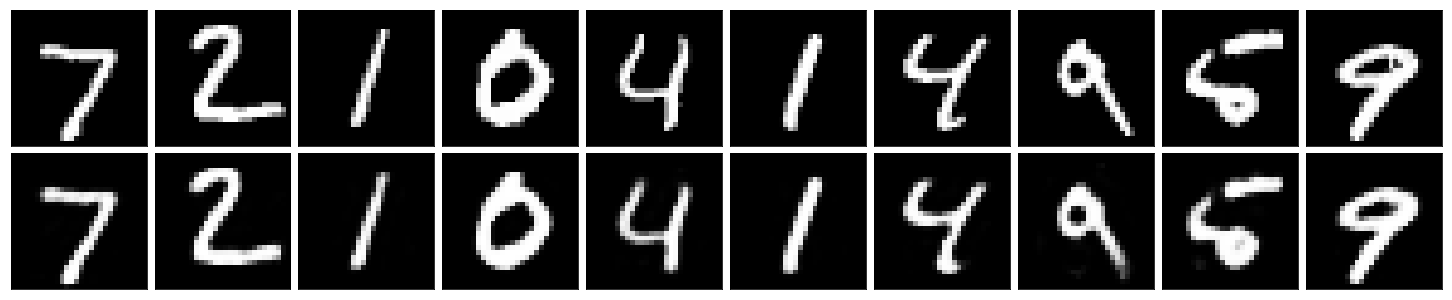

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={inputs_: in_imgs})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [28]:
sess.close()

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.

In practice, autoencoders aren't actually better at compression compared to typical methods like JPEGs and MP3s. But, they are being used for noise reduction, which you'll also build.